In [ ]:
!pip install ase
!pip install rdkit

In [ ]:
!git clone https://github.com/Arshnoor7/Machine_Learning_Project

fatal: destination path 'Machine_Learning_Project' already exists and is not an empty directory.


In [ ]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi-headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name=f"encoder_{i}_multiheadattention",  # Replaced '/' with '_'
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_att_layernormalization"
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name=f"encoder_{i}_ffn",  # Replaced '/' with '_'
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name=f"encoder_{i}_ffn_layernormalization"
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [ ]:
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 128
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    # DSPATH="/content/elementsem/data/"
    DSPATH="/content/HIV.csv"
    PREPATH="/content/Machine_Learning_Project/models/pretrained/"
    PATH="/content/Machine_Learning_Project/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
! wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv

--2024-11-20 19:05:19--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.117.154, 3.5.161.117, 52.219.121.106, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.117.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2193844 (2.1M) [text/csv]
Saving to: ‘HIV.csv.1’

HIV.csv.1           100%[===================>]   2.09M  --.-KB/s    in 0.1s    

2024-11-20 19:05:20 (19.7 MB/s) - ‘HIV.csv.1’ saved [2193844/2193844]



In [ ]:
ds = 'HIV'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [ ]:
from rdkit import Chem
import gzip
#df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')
#with gzip.open('clintox.csv.gz', 'rb') as file:
#    df = pd.read_csv(file)
df = pd.read_csv('HIV.csv')
print(df.head())
types=[]
for i in df['smiles']:
  m = Chem.MolFromSmiles(i)
  m2 = Chem.AddHs(m)
  types.append([atom.GetSymbol() for atom in m2.GetAtoms()])
labels  = to_categorical(np.asarray(df['HIV_active']))
uniquelbls=len(np.unique(np.asarray(df['HIV_active'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


                                              smiles activity  HIV_active
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0


[19:05:49] WARNING: not removing hydrogen atom without neighbors
[19:05:49] WARNING: not removing hydrogen atom without neighbors


vocabSize:  101


In [ ]:
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [ ]:
len(types)

41127

# Convert types to integers

In [ ]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)


In [ ]:
inputC = Input(shape=(config.MAX_LEN,), dtype=tf.int32, name='types')
z = create_elembert_model(inputC, config)

e = Lambda(lambda x: x[:, 0], name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax", name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

# plot_model(model, show_shapes=True, show_layer_names=True, to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname + "_log.csv", append=True)

mname = config.PATH + config.MNAME + ds + '_%s_E_%s_H_%s_L_%s_bert.keras' % (
    config.MVER, config.EMBED_DIM, config.NUM_HEAD, config.NUM_LAYERS
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    mname,
    verbose=2,
    mode='min',
    save_freq=20000,
)

callbacks_list = [checkpoint, csv_logger]

print('dataLen: ', x3.shape, labels.shape)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ types (InputLayer)        │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ element_embdgs            │ (None, 256, 32)        │          3,232 │ types[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 256, 32)        │              0 │ element_embdgs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_multiheadatten… │ (None, 256, 32)        │          4,224 │ add_15[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_15[0][0],          │
│                           │                        │                │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_dropout     │ (None, 256, 32)        │              0 │ encoder_0_multiheadat… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 256, 32)        │              0 │ add_15[0][0],          │
│                           │                        │                │ encoder_0_att_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_layernorma… │ (None, 256, 32)        │             64 │ add_16[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn             │ (None, 256, 32)        │          2,112 │ encoder_0_att_layerno… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_dropout     │ (None, 256, 32)        │              0 │ encoder_0_ffn[0][0]    │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 256, 32)        │              0 │ encoder_0_att_layerno… │
│                           │                        │                │ encoder_0_ffn_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_layernorma… │ (None, 256, 32)        │             64 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1_multiheadatten… │ (None, 256, 32)        │          4,224 │ encoder_0_ffn_layerno… │
│ (MultiHeadAttention)      │                        │                │ encoder_0_ffn_layerno… │
│                           │                        │                │ encoder_0_ffn_layerno… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1_att_dropout     │ (None, 256, 32)        │              0 │ encoder_1_multiheadat… │
│ (Dropout)                 │                        │                │                        │
├──────────────────────

 Total params: 16,226 (63.38 KB)

 Trainable params: 16,226 (63.38 KB)

 Non-trainable params: 0 (0.00 B)

dataLen:  (41127, 256) (41127, 2)


In [ ]:
epochs=config.BATCH_SIZE

p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:int(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Epoch 1/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - auc_3: 0.9633 - loss: 0.1739 - val_auc_3: 0.9722 - val_loss: 0.1515
Epoch 2/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - auc_3: 0.9723 - loss: 0.1479 - val_auc_3: 0.9784 - val_loss: 0.1435
Epoch 3/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc_3: 0.9763 - loss: 0.1423 - val_auc_3: 0.9795 - val_loss: 0.1425
Epoch 4/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc_3: 0.9780 - loss: 0.1392 - val_auc_3: 0.9794 - val_loss: 0.1420
Epoch 5/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - auc_3: 0.9782 - loss: 0.1385 - val_auc_3: 0.9793 - val_loss: 0.1413
Epoch 6/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc_3: 0.9782 - loss: 0.1375 - val_auc_3: 0.9794 - val_loss: 0.1407
Epoch 7/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc_3: 0.9788 - loss: 0.1370 - val_auc_3: 0.9800 - val_loss: 0.1411
Epoch 8/128
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - auc_3: 0.9784 - loss: 0.1371 - val_auc_3: 0.9798 - val_loss: 0.1409
Epoch 

# Save results

In [ ]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['smiles']
#dbresults['ids'] = df['CID']
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = testidx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


# Postprocessing

In [ ]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [ ]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: [0. 1. 1. ... 1. 1. 1.]
/content/Machine_Learning_Project/models/elembertR_HIV_V0_E_32_H_2_L_2_bert.keras  AUC: 0.97744393


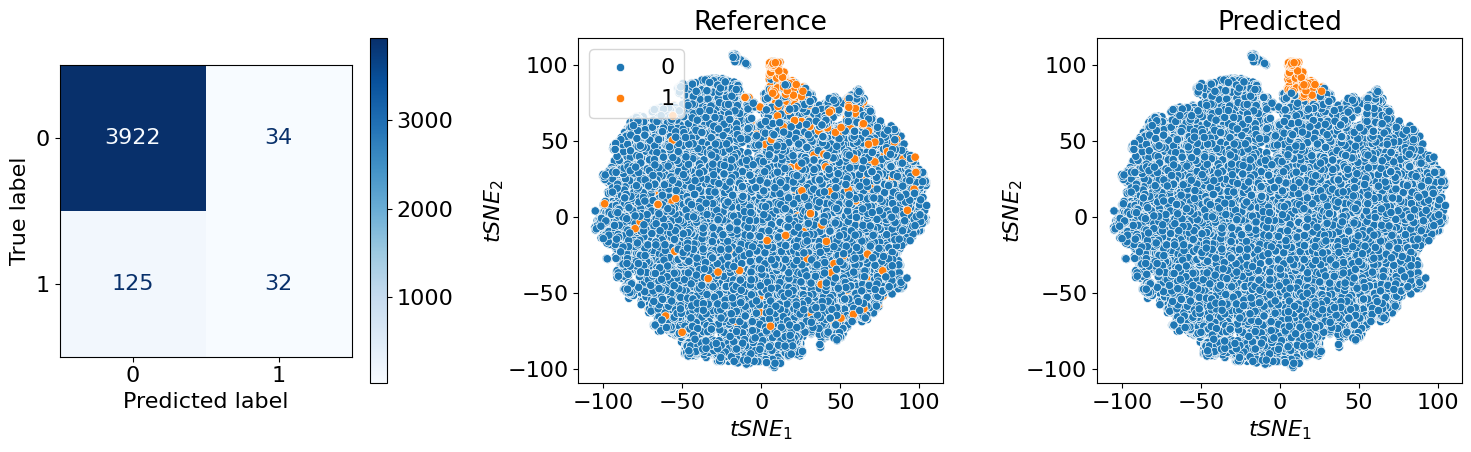

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'][dbresults['testidx']].argmax(axis=-1)
y_classes = dbresults['y_cls'][dbresults['testidx']].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'][dbresults['testidx']], dbresults['pred_cls'][dbresults['testidx']])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")